# Plant Disease Image Recognition Anaylsis

# Imports

In [56]:
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageFile

from tensorflow.keras.layers import Dense, Dropout, Conv2D, GlobalAvgPool2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3

from sklearn.preprocessing import LabelEncoder

# Constants

In [4]:
PATH = "/Users/maukanmir/Downloads/archive/"
train_path, test_path, val_path = PATH + "Train/", PATH + "Test/", PATH +"Validation/"
INPUT_SHAPE = (224,224, 3)
BATCH_SIZE = 32

# Functions

In [54]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_process_images(img_path, target_size=INPUT_SHAPE):
  try:
    with Image.open(img_path) as img:
      img = img.resize(target_size[:2])
      img = img.convert("RGB")
      
      img_arr = np.array(img)/255.0
      img_arr = img_arr.astype(np.float32)
      return img_arr
  except IOError as e:
    print(f"The following image failed to process {e}")
    return None

def grab_images(path):
  
  X, y = [], []
  
  for root, dirs, files in os.walk(path):
    for file in files:
      if file.lower().endswith((".png", ".jpeg", ".jpg")):
        path = os.path.join(root, file)
        img = load_process_images(path)
        if img is not None:
          X.append(img)
          label = root.split(os.sep)[-1]
          y.append(label)
  
  X, y = np.array(X), np.array(y)
  return X, y

def check_class_imbalances(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 6))
  plt.pie(counts,labels=unique, autopct="%1.1f%%", startangle=140)
  plt.title("Target Class Imbalance")
  plt.show()
  
  plt.figure(figsize=(10, 6))
  sns.countplot(x=target)
  plt.title("Target Class Imbalance")
  plt.xlabel("Classes")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def plot_images(images, labels, num_images=12, img_size=INPUT_SHAPE):
  
  indcies = np.arange(len(images))
  np.random.shuffle(indcies)
  plt.figure(figsize=(10, 10))
  
  for i in range(num_images):
    plt.subplot(3,4,i+1)
    idx = indcies[i]
    img=images[idx].reshape(img_size)
    plt.imshow(img)
    plt.title(labels[idx])
    plt.axis("off")
  plt.show()

def create_model(n_classes, input_shape=INPUT_SHAPE):
  
  model = Sequential([
    Conv2D(32, (3,3), input_shape=INPUT_SHAPE, activation="relu"),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), input_shape=INPUT_SHAPE, activation="relu"),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), input_shape=INPUT_SHAPE, activation="relu"),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), input_shape=INPUT_SHAPE, activation="relu"),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(n_classes, activation="softmax")
  ]
  )
  
  model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
  )
  
  model.summary()
  
  return model

def plot_learning_curves(history):
  
  acc, val_acc = history.history["accuracy"], history.history["val_accuracy"]
  loss, val_loss = history.history["loss"], history.history["val_loss"]
  epochs = range(1, len(acc)+1)
  
  plt.figure(figsize=(10, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc,"bo-", label="Training Accuracy")
  plt.plot(epochs, val_acc,"gs-", label="Validation Accuracy")
  plt.xlabel("Epcohs")
  plt.ylabel("Accuracy")
  plt.title("Training and Validation Accuracy")
  plt.xticks(rotation=45)
  plt.legend()
  
  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss,"bo-", label="Training Loss")
  plt.plot(epochs, val_loss,"gs-", label="Validation Loss")
  plt.xlabel("Epcohs")
  plt.ylabel("Loss")
  plt.title("Training and Validation Loss")
  plt.xticks(rotation=45)
  plt.legend()
  
  plt.tight_layout()
  plt.show()

# Load Data

In [9]:
X_train, y_train = grab_images(train_path)
X_val, y_val = grab_images(val_path)
X_test, y_test = grab_images(test_path)

# Dataset shape

In [10]:
print(f"X Train Shape:{X_train.shape}, y Train Shape:{y_train.shape}")
print(f"X Test Shape:{X_test.shape}, y Test Shape:{y_test.shape}")
print(f"X Val Shape:{X_val.shape}, y Val Shape:{y_val.shape}")

X Train Shape:(1322, 224, 224, 3), y Train Shape:(1322,)
X Test Shape:(150, 224, 224, 3), y Test Shape:(150,)
X Val Shape:(60, 224, 224, 3), y Val Shape:(60,)


# Check Class Imabalance

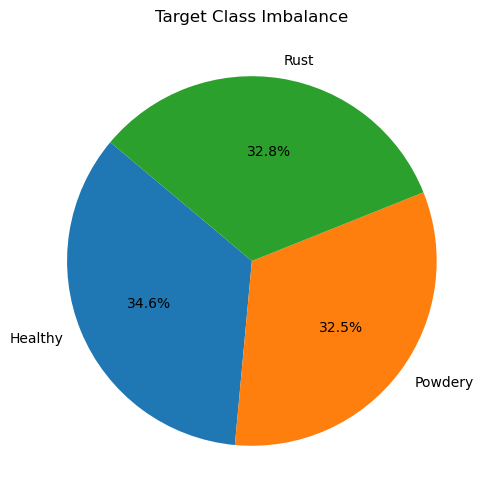

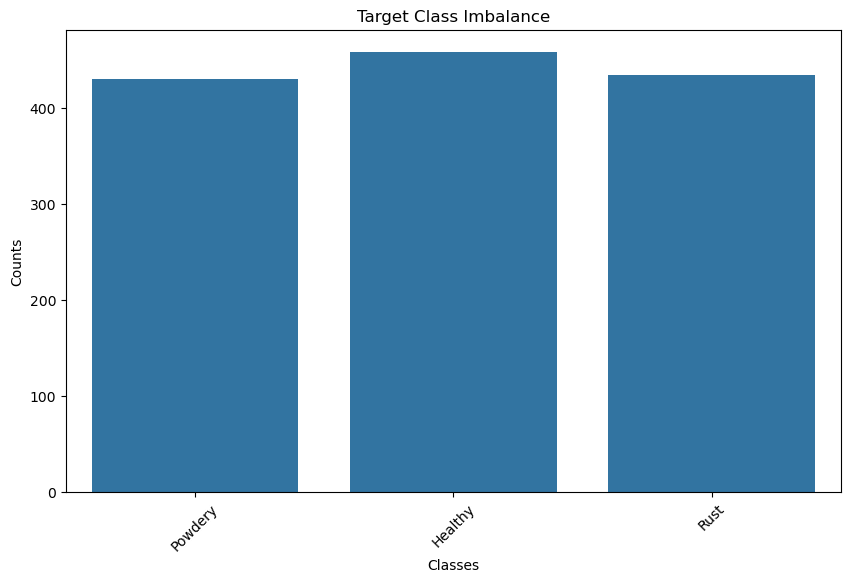

In [14]:
check_class_imbalances(y_train)

# Fairly Balanced Dataset

# Let's take a look at our images

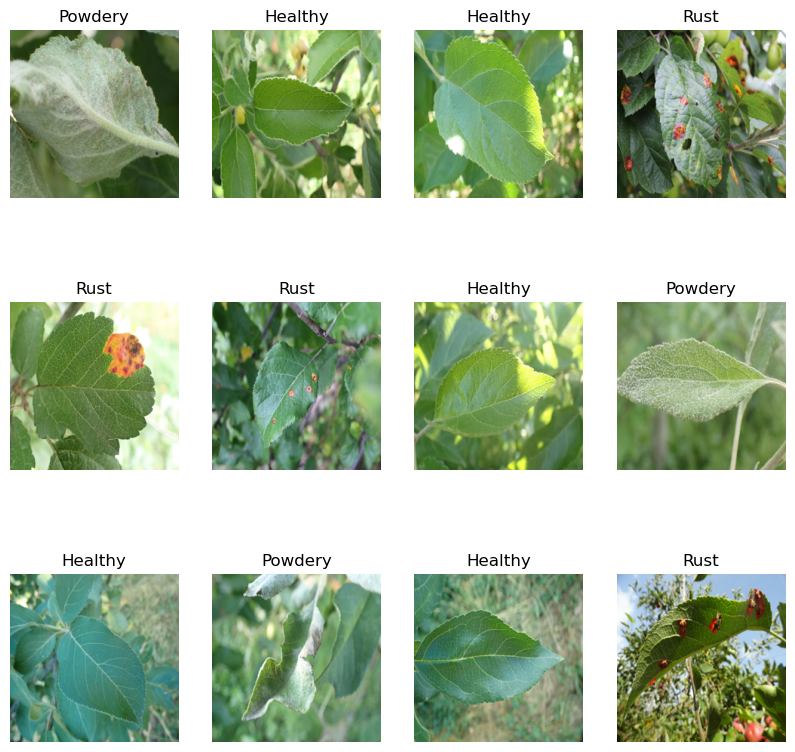

In [26]:
plot_images(X_train, y_train)

# Format Dataset

In [30]:
encoder = LabelEncoder()

y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)
y_val_encoded = encoder.transform(y_val)

NUM_CLASSES = len(encoder.classes_)

one_hot_encoded_y_train = to_categorical(y_train_encoded, num_classes=NUM_CLASSES)
one_hot_encoded_y_test = to_categorical(y_test_encoded, num_classes=NUM_CLASSES)
one_hot_encoded_y_val = to_categorical(y_val_encoded, num_classes=NUM_CLASSES)

In [35]:
model = create_model(NUM_CLASSES)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 128)      0

# Read in Dataset

In [45]:
train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=40,
  horizontal_flip=True,
  height_shift_range=0.2,
  width_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  fill_mode="nearest"
  
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
  train_path +"Train/",
  target_size=INPUT_SHAPE[:2],
  batch_size=BATCH_SIZE,
  class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
  val_path + "Validation/",
  target_size=INPUT_SHAPE[:2],
  batch_size=BATCH_SIZE,
  class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
  test_path +"Test/",
  target_size=INPUT_SHAPE[:2],
  batch_size=BATCH_SIZE,
  class_mode="categorical"
)

Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


# Create Early Stopping

In [44]:
steps_per_epoch = X_train.shape[0]// BATCH_SIZE
validation_steps_per_epoch = X_val.shape[0]// BATCH_SIZE
test_steps_per_epoch = X_test.shape[0]// BATCH_SIZE


early_stopping = EarlyStopping(
  monitor="val_loss",
  min_delta=0.01,
  patience=10,
  verbose=0,
  restore_best_weights=True,
  mode="min"
  
)

# Train Model

In [47]:
history = model.fit(
  train_generator,
  steps_per_epoch=steps_per_epoch,
  validation_data=val_generator,
  validation_steps=validation_steps_per_epoch,
  epochs=100,
  verbose=0,
  callbacks=[early_stopping]
)

# Evaluate Model

In [48]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_steps_per_epoch)
print("Test Accuracy is: ", test_acc)

4/4 [==============================] - 6s 2s/step - loss: 0.2853 - accuracy: 0.9375
Test Accuracy is:  0.9375


# Plot Learning Curves

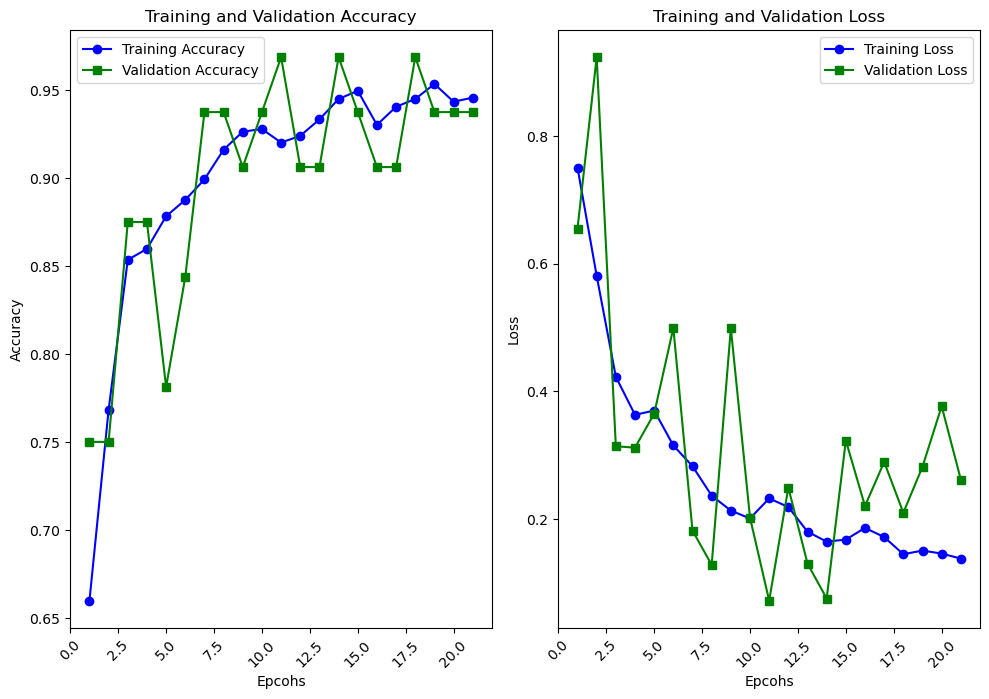

In [55]:
plot_learning_curves(history)

# Given that we have a small amount of data for our test and validation data, the model may not be able to generalize to the small example size well. However, our test accuracy is over 90% which is fantastic, lets try transfer learning and see if we can get any more improvements.

In [58]:
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)

for layer in base_model.layers:
  layer.trainable = False

X = base_model.output
X = GlobalAvgPool2D()(X)
X = Dense(128, activation="relu")(X)
X = Dropout(0.2)(X)
prediction = Dense(NUM_CLASSES, activation="softmax")(X)

model_v3 = Model(inputs=base_model.input, outputs=prediction)

model_v3.compile(
  loss="categorical_crossentropy",
  optimizer="adam",
  metrics=["accuracy"]
)

history = model_v3.fit(
  train_generator,
  steps_per_epoch=steps_per_epoch,
  verbose=0,
  validation_steps=validation_steps_per_epoch,
  validation_data=val_generator,
  epochs=100,
  callbacks=[early_stopping]
)

In [59]:
test_loss, test_acc = model_v3.evaluate(test_generator, steps=test_steps_per_epoch)
print('Test accuracy', test_acc)

4/4 [==============================] - 7s 2s/step - loss: 0.1571 - accuracy: 0.9609
Test accuracy 0.9609375
